# Notebook: pyolimp - Примеры симуляции

### 📦 Импорт библиотек

В этом разделе выполняется импорт необходимых модулей:

- `sys` — для добавления пути к корню проекта;
- `torch` — основная библиотека для работы с тензорами;
- `Tensor` — тип из `torch`, используемый для аннотирования аргументов;
- `matplotlib.pylab as plt` — модуль для построения графиков и отображения изображений;
- `pi` из `math` — значение числа π, может использоваться для дальнейших вычислений (хотя в текущей функции не используется).

In [2]:
import sys
sys.path.append("../../../")

In [3]:
import torch
from torch import Tensor
from matplotlib import pylab as plt
from math import pi

### 🖼️ Визуализация изображения

Функция `show_one` используется для отображения одного изображения с заголовком.  
Перед выводом она проверяет наличие `NaN` в тензоре, чтобы избежать ошибок отображения.

In [4]:
def show_one(image: Tensor, title: str) -> None:
    if image.isnan().any():
        raise ValueError("has nan")
    fig, ax1 = plt.subplots(dpi=72, figsize=(6, 4.5), ncols=1, nrows=1)
    plt.title(title)
    ax1.imshow(image)

### 🔍 Метод SCA (Simplified Conic Approximation)

Метод **SCA** — приближённая модель построения **Функции Рассеяния Точки (ФРТ)**  
для моделирования искажений изображения, вызванных аберрациями зрения.  
ФРТ формируется в виде **нормализованного эллипса**, параметры которого  
задаются сферической и цилиндрической составляющими, а также осью астигматизма.

#### 🧾 Вход:
- сферическая аберрация `sphere_dpt` (в диоптриях);
- цилиндрическая аберрация `cylinder_dpt` (в диоптриях);
- угол астигматизма `angle_rad` (в радианах);
- диаметр зрачка `pupil_diameter_mm` (в мм);
- масштаб `am2px` (угловые минуты в пиксели);
- размер ФРТ (ширина и высота, например 64×64 пикселя).

#### 📤 Выход:
- **ФРТ**: 2D тензор `Tensor[H, W]`,  
  значащий нормализованное распределение интенсивности,  
  задающее форму и направление искажений изображения.

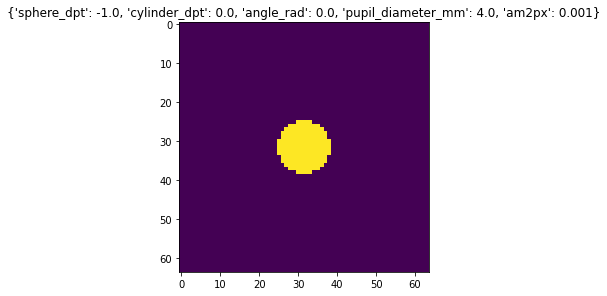

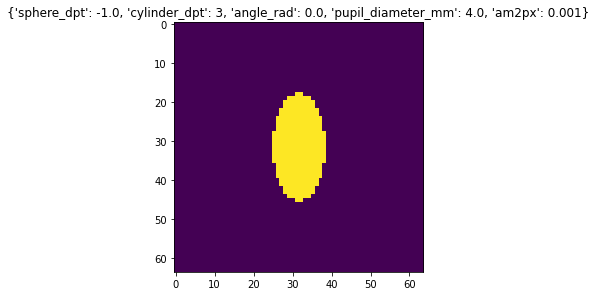

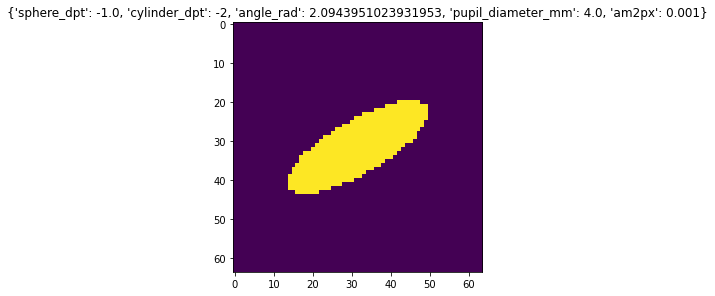

In [5]:
from olimp.simulate.psf_sca import PSFSCA


params = {
    "sphere_dpt": -1.0,
    "cylinder_dpt": 0.0,
    "angle_rad": 0.0,
    "pupil_diameter_mm": 4.0,
    "am2px": 0.001,
}

params1 = {**params}
show_one(PSFSCA(64, 64)(**params1), f"{params1}")
params2 = {**params, "cylinder_dpt": 3}
show_one(PSFSCA(64, 64)(**params2), f"{params2}")
params3 = {**params, "cylinder_dpt": -2, "angle_rad": pi / 1.5}
show_one(PSFSCA(64, 64)(**params3), f"{params3}")

### 🗃️ Класс `PSFSCADataset`

Класс **PSFSCADataset** — генератор набора **Функций Рассеяния Точки (ФРТ)**  
по упрощённой конусной аппроксимации (SCA) для синтетической генерации искажений,  
вызванных оптическими аберрациями зрения.

#### 🧾 Параметры конструктора:
- **width**, **height** — размеры выходного ФРТ в пикселях (например, 64×64).
- **sphere_dpt** — распределение сферической аберрации в диоптриях; словарь:
  - `name`: строка, например `"uniform"`
  - `a`: нижняя граница диапазона (float), например -2.0
  - `b`: верхняя граница диапазона (float), например 0.0
- **cylinder_dpt** — распределение цилиндрической аберрации в диоптриях; аналогичный формат, например `a=-2.0`, `b=2.0`.
- **angle_deg** — распределение оси астигматизма в градусах; словарь с `a=0.0`, `b=180.0`.
- **pupil_diameter_mm** — распределение диаметра зрачка в миллиметрах; словарь с `a=3.0`, `b=5.0`.
- **am2px** — масштаб перевода угловых минут в пиксели (например, 0.001).
- **seed** — начальное значение генератора случайных чисел для воспроизводимости (например, 42).
- **size** — общее число выборок в датасете (например, 100).

#### 📥 Как использовать:
1. Создаёте экземпляр `PSFSCADataset` с нужными параметрами (ширина, высота, распределения, масштаб, seed, размер).
2. Получаете элемент через `dataset[idx]`, где `idx` от 0 до `size-1`.
3. Каждый элемент — тензор формы `(1, H, W)`, содержащий нормализованную ФРТ.

#### 📤 Выход каждого элемента:
- **ФРТ**: 2D тензор `Tensor[1, H, W]` — нормализованное распределение интенсивности, моделирующее точечный источник с учётом заданных аберраций.
- **Параметры выборки**: sphere_dpt, cylinder_dpt, angle_deg, pupil_diameter_mm (можно вывести вручную при генерации для анализа).


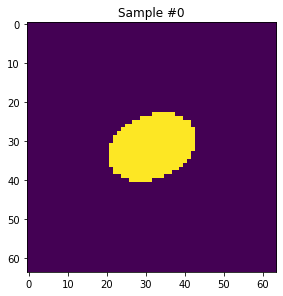

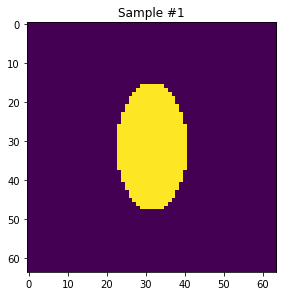

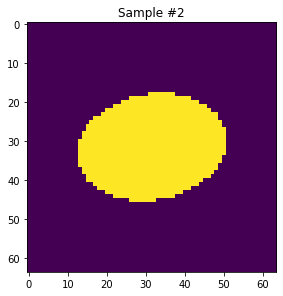

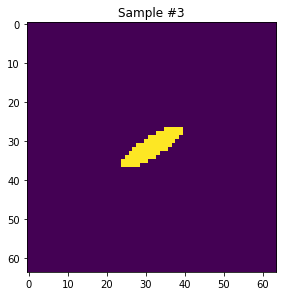

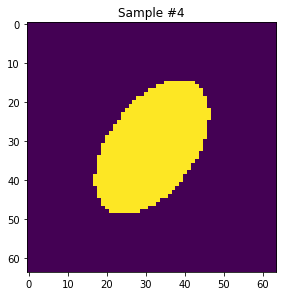

In [6]:
from olimp.precompensation.nn.dataset.psf_sca import PSFSCADataset

dataset = PSFSCADataset(
    width=64,
    height=64,
    sphere_dpt={"name": "uniform", "a": -2.0, "b": 0.0},       # uniform в диапазоне [-2, 0]
    cylinder_dpt={"name": "uniform", "a": -2.0, "b": 2.0},     # то, что у вас уже было
    angle_deg={"name": "uniform", "a": 0.0,   "b": 180.0},     # то, что у вас уже было
    pupil_diameter_mm={"name": "uniform", "a": 3.0, "b": 5.0}, # uniform, например, от 3 до 5 мм
    am2px=0.001,
    seed=42,
    size=100
)

# 2) Берём первые N=5 через прямой доступ
for idx in range(5):
    psf = dataset[idx]       # Tensor shape (1, H, W)
    # Можно вывести параметры, которые были заэмплированы:
    # Но поскольку create_distribution не хранит историю, параметры в title укажем схематично.
    show_one(psf[0], title=f"Sample #{idx}")

### 🔍 Метод PSFGauss (Гауссовская функция рассеяния точки)

Метод **PSFGauss** используется для генерации **функции рассеяния точки (ФРТ)**  
в виде двумерного нормализованного **анизотропного гауссовского распределения**  
с возможностью задания ориентации эллипса и степени размытия по осям.

#### 🧾 Вход:
- `center_x`, `center_y` — координаты центра ФРТ (в пикселях);
- `sigma_x`, `sigma_y` — стандартные отклонения по осям X и Y (характеризуют размытие);
- `theta` — угол поворота эллипса (в радианах);
- размер ФРТ (ширина и высота, например 64×64 пикселя).

#### 📤 Выход:
- **ФРТ**: 2D тензор `Tensor[H, W]`,  
  представляющий собой нормализованную карту интенсивности рассеяния.

> Применяется для имитации искажений, аналогичных оптическому размытию в системах зрения и изображений.


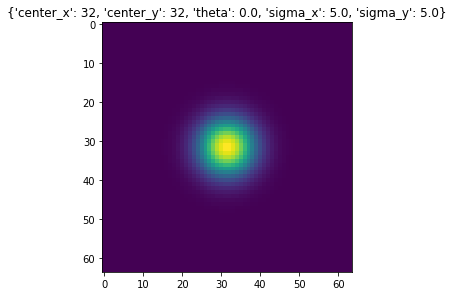

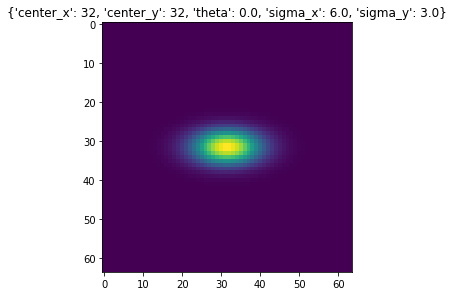

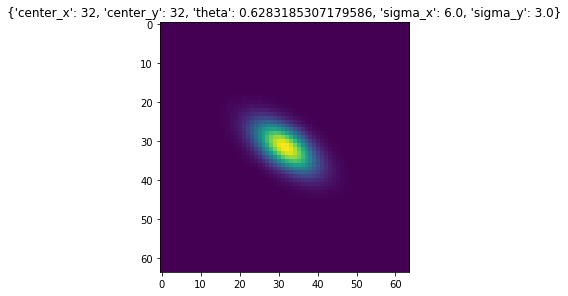

In [7]:
from olimp.simulate.psf_gauss import PSFGauss

params = {
    "center_x": 32,
    "center_y": 32,
    "theta": 0.0,
    "sigma_x": 5.0,
    "sigma_y": 5.0,
}

show_one(PSFGauss(64, 64)(**params), f"{params}")
params2 = {**params, "sigma_x": 6.0, "sigma_y": 3.0}
show_one(PSFGauss(64, 64)(**params2), f"{params2}")
params3 = {**params, "sigma_x": 6.0, "sigma_y": 3.0, "theta": pi / 5}
show_one(PSFGauss(64, 64)(**params3), f"{params3}")

### 🗃️ Класс `PsfGaussDataset`

Класс **PsfGaussDataset** — генератор набора **Гауссовских Функций Рассеяния Точки (ФРТ)**  
для синтетической генерации размытий, моделируемых двумерной анизотропной гауссианой.

#### 🧾 Параметры конструктора:
- **width**, **height** — размеры выходного ФРТ в пикселях (например, 64×64).
- **center_x** — распределение координаты центра по X; словарь:
  - `name`: строка, например `"uniform"`
  - `a`: нижняя граница диапазона (float), например 31.0
  - `b`: верхняя граница диапазона (float), например 33.0
- **center_y** — распределение координаты центра по Y; аналогичный формат, например `a=31.0`, `b=33.0`.
- **theta** — распределение угла поворота гауссианы в градусах; словарь с `a=0.0`, `b=180.0`.
- **sigma_x** — распределение стандартного отклонения по X (в пикселях); словарь с `a=1.0`, `b=5.0`.
- **sigma_y** — распределение стандартного отклонения по Y (в пикселях); аналогичный формат, например `a=1.0`, `b=5.0`.
- **seed** — начальное значение генератора случайных чисел для воспроизводимости (например, 42).
- **size** — общее число выборок в датасете (например, 10000).

#### 📥 Как использовать:
1. Создаёте экземпляр `PsfGaussDataset` с нужными параметрами (ширина, высота, распределения, seed, размер).  
2. Получаете элемент через `dataset[idx]`, где `idx` от 0 до `size-1`.  
3. Каждый элемент — тензор формы `(1, H, W)`, содержащий одноканальную гауссовскую ФРТ.

#### 📤 Выход каждого элемента:
- **Гауссовская ФРТ**: 2D тензор `Tensor[1, H, W]` — анизотропная гауссиана с заданными параметрами.  
- **Параметры выборки**: `center_x`, `center_y`, `theta`, `sigma_x`, `sigma_y` (можно вывести вручную при генерации для анализа).


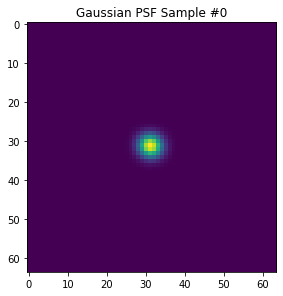

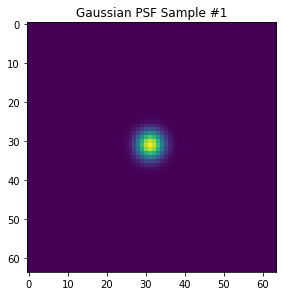

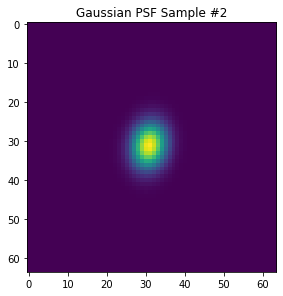

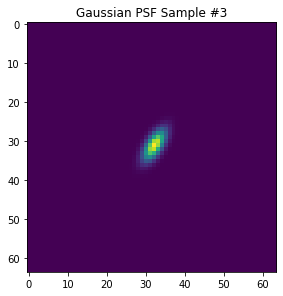

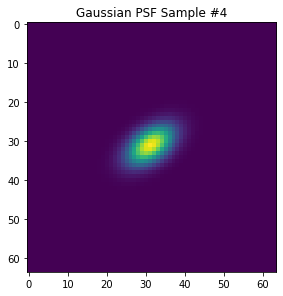

In [13]:
from olimp.precompensation.nn.dataset.psf_gauss import PsfGaussDataset

dataset = PsfGaussDataset(
    width=64,
    height=64,
    center_x={"name": "uniform", "a": 31.0,  "b": 33.0},   # центр по X в пикселях от 0 до 63
    center_y={"name": "uniform", "a": 31.0,  "b": 33.0},   # центр по Y в пикселях от 0 до 63
    theta={"name": "uniform",   "a": 0.0,  "b": 180.0},   # угол поворота в градусах
    sigma_x={"name": "uniform", "a": 1.0,  "b": 5.0},    # sigma по X в пикселях
    sigma_y={"name": "uniform", "a": 1.0,  "b": 5.0},    # sigma по Y в пикселях
    seed=42,
    size=100
)

# 2) Берём первые N=5 через прямой доступ и визуализируем
for idx in range(5):
    psf = dataset[idx]       # Tensor shape (1, H, W)
    show_one(psf[0], title=f"Gaussian PSF Sample #{idx}")


### 👁 Метод RefractionDistortion

Класс **RefractionDistortion** моделирует искажения изображения, вызванные **рефракционными аномалиями** зрения,  
такими как близорукость, дальнозоркость и астигматизм. Метод реализует **свёртку изображения с ФРТ (PSF)**  
в частотной области, что позволяет точно смоделировать эффект, наблюдаемый на сетчатке глаза.

#### 🧾 Вход:
- Функция рассеяния точки `PSF` (тензор `Tensor[H, W]`), сдвинутая с помощью `fftshift`;
- Изображение (при вызове `RefractionDistortion()(image)` внутри пайплайна).

#### 📤 Выход:
- Искажённое изображение, имитирующее восприятие наблюдателем с заданными аберрациями.


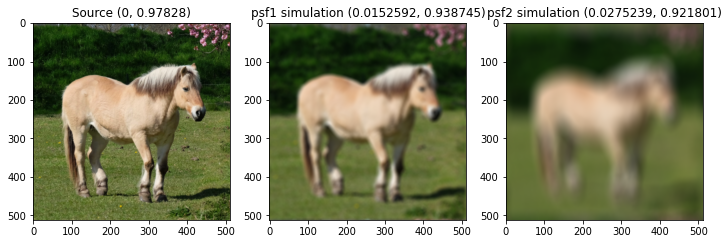

In [8]:
from olimp.simulate.refraction_distortion import RefractionDistortion
from olimp.simulate._demo_distortion import demo


def demo_simulate():
    psf1 = PSFSCA(512, 512)()
    yield RefractionDistortion()(torch.fft.fftshift(psf1)), "psf1"

    psf2 = PSFSCA(512, 512)(sphere_dpt=-3, cylinder_dpt=-2)
    yield RefractionDistortion()(torch.fft.fftshift(psf2)), "psf2"


demo("RefractionDistortion", demo_simulate, on="horse.jpg", size=(512, 512))

### 👁 Метод ColorBlindnessDistortion

Класс **ColorBlindnessDistortion** реализует симуляцию восприятия изображения людьми  
с различными типами **дальтонизма**. Основан на преобразовании изображения в цветовое пространство LMS  
и модификации компонент, имитирующих утрату чувствительности одного из трёх типов колбочек.

#### 🧾 Вход:
- Тип цветовой слепоты:
  - `"protan"` — протанопия (нечувствительность к красному);
  - `"deutan"` — дейтеранопия (нечувствительность к зелёному);
  - `"tritan"` — тританопия (нечувствительность к синему).

#### 📤 Выход:
- Искажённое изображение, соответствующее восприятию человека с указанным типом дальтонизма.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.119602986..1.0000002].


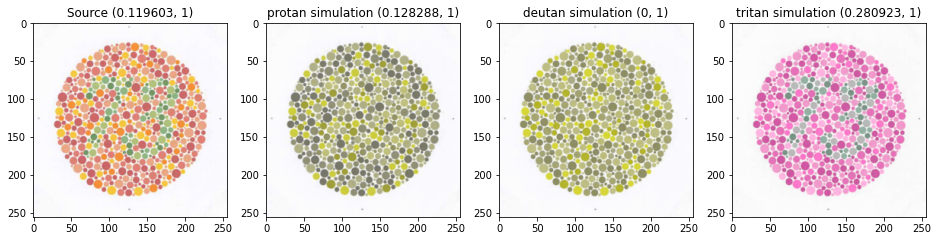

In [15]:
from olimp.simulate.color_blindness_distortion import ColorBlindnessDistortion
from olimp.precompensation.nn.dataset.value import ValueDataset

def demo_simulate():
    yield ColorBlindnessDistortion.from_type("protan")(), "protan"
    yield ColorBlindnessDistortion.from_type("deutan")(), "deutan"
    yield ColorBlindnessDistortion.from_type("tritan")(), "tritan"


demo("ColorBlindnessDistortion", demo_simulate)

### 🗃️ Demo `ColorBlindnessDistortion` по случайным углам

Демонстрация применения искажения цветовой слепоты с помощью класса **ColorBlindnessDistortion**,  
где угол оттенка выбирается из равномерного распределения.

#### 🧾 Настройки датасета углов:
- **value** — параметры распределения (`DistributionParams`):  
  - `name`: `"uniform"`  
  - `a`: `33.0` (нижняя граница, в градусах)  
  - `b`: `360.0` (верхняя граница, в градусах)  
- **seed** — начальное значение генератора для воспроизводимости (`123`).  
- **size** — общее число образцов в датасете (`1000`).

#### 📥 Функция-генератор `demo_simulate`:
1. Перебирает первые 3 индекса из `angle_ds`.  
2. Для каждого индекса:
   - Берёт угол: `angle = float(angle_ds[idx].item())`.  
   - Создаёт искажатель: `distort = ColorBlindnessDistortion(angle)`.  
   - Получает функцию: `apply_fn = distort()`.  
   - Возвращает пару `(apply_fn, f"{angle:.1f}°")`.

#### 🚀 Запуск демо:
```python
demo("ColorBlindnessDistortion (углы)", demo_simulate)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.119602986..1.0000002].


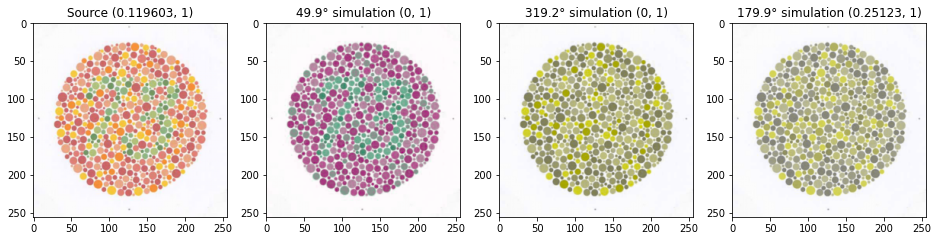

In [32]:
from olimp.simulate.color_blindness_distortion import ColorBlindnessDistortion

angle_ds = ValueDataset(
    value={"name": "uniform", "a": 33.0, "b": 360.0},
    seed=123,
    size=1000
)

def demo_simulate():
    for idx in range(3):
        angle = float(angle_ds[idx].item())
        distort = ColorBlindnessDistortion(angle)
        apply_fn = distort()                    
        yield apply_fn, f"{angle:.1f}°"

demo("ColorBlindnessDistortion (5 angles)", demo_simulate)